In [ ]:
## installs fastai v2 (Google Colab comes with fastai v1 by default)
# this will also ask permision to access your Google Drive
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 719 kB 5.3 MB/s 
     |████████████████████████████████| 365 kB 56.6 MB/s 
     |████████████████████████████████| 1.3 MB 54.2 MB/s 
     |████████████████████████████████| 4.7 MB 41.3 MB/s 
     |████████████████████████████████| 120 kB 65.8 MB/s 
     |████████████████████████████████| 115 kB 64.8 MB/s 
     |████████████████████████████████| 212 kB 62.8 MB/s 
     |████████████████████████████████| 127 kB 63.9 MB/s 
     |████████████████████████████████| 6.6 MB 42.1 MB/s 
Mounted at /content/gdrive


In [ ]:
# the variable gdrive now contains you Google Drive path
# this is a pathlib Path object
# we can create new file paths from it using the '/' operator
# See: https://realpython.com/python-pathlib/
from fastbook import *
gdrive

Path('/content/gdrive/My Drive')

In [ ]:
# See: https://www.geeksforgeeks.org/python-os-path-exists-method/
if not (gdrive / 'camvid_tiny').is_dir():
  # https://www.geeksforgeeks.org/python-os-mkdir-method/
  os.mkdir(gdrive / 'camvid_tiny')

In [ ]:
import os
path = untar_data(URLs.CAMVID_TINY, data = gdrive / 'camvid_tiny')


In [ ]:
os.listdir(path)

['labels', 'codes.txt', 'images', 'models', 'trained_unet.pkl']

In [ ]:
# codes.txt contains the label code for our pixels 
# class 0 is Animal, class 1 is Archway
# class 2 is Bicyclist, etc. 
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter',
       'OtherMoving', 'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone', 'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

/content/gdrive/My Drive/camvid_tiny/camvid_tiny/images/0016E5_08001.png


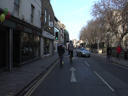

In [ ]:
from PIL import Image
unlabeled_images = os.listdir(path / 'images')
print(path / 'images' / unlabeled_images[0])
image = Image.open(path / 'images' / unlabeled_images[0])
image

(96, 128, 3)


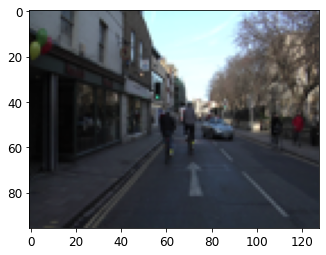

In [ ]:
import matplotlib.pyplot as plt
# let's see its dimensions 
pix = np.array(image)
print(pix.shape)
plt.imshow(pix);

In [ ]:
# check out what Path.stem and Path.suffix give us
Path(unlabeled_images[0]).stem, Path(unlabeled_images[0]).suffix

('0016E5_08001', '.png')

In [ ]:
# in the labels folder we have a 0016E5_08370_P.png file with a label for every pixel in the image
label_file_path = f'{Path(unlabeled_images[0]).stem}_P{Path(unlabeled_images[0]).suffix}' 
label_file_path 

'0016E5_08001_P.png'

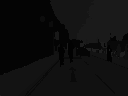

In [ ]:
# it's a gray scale image
label = Image.open(path / 'labels' / label_file_path)
label

2 31


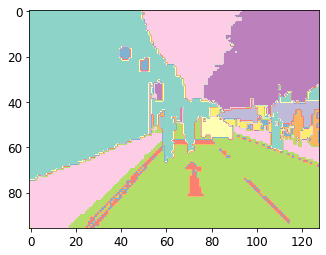

In [ ]:
# matplotlib allows to view it with a colormap
import numpy as np
label_array = np.array(label)
print(label_array.min(), label_array.max())
plt.imshow(label_array, cmap='Set3');

In [ ]:
# get the path of the matching image
# getting the label names for all files
label_names = [path/'labels'/f'{Path(o).stem}_P{Path(o).suffix}'  for o in unlabeled_images]
label_names[0:10]

[Path('/content/gdrive/My Drive/camvid_tiny/camvid_tiny/labels/0016E5_08001_P.png'),
 Path('/content/gdrive/My Drive/camvid_tiny/camvid_tiny/labels/Seq05VD_f01440_P.png'),
 Path('/content/gdrive/My Drive/camvid_tiny/camvid_tiny/labels/Seq05VD_f04650_P.png'),
 Path('/content/gdrive/My Drive/camvid_tiny/camvid_tiny/labels/0016E5_05310_P.png'),
 Path('/content/gdrive/My Drive/camvid_tiny/camvid_tiny/labels/0016E5_05730_P.png'),
 Path('/content/gdrive/My Drive/camvid_tiny/camvid_tiny/labels/Seq05VD_f03150_P.png'),
 Path('/content/gdrive/My Drive/camvid_tiny/camvid_tiny/labels/0016E5_06810_P.png'),
 Path('/content/gdrive/My Drive/camvid_tiny/camvid_tiny/labels/0016E5_08125_P.png'),
 Path('/content/gdrive/My Drive/camvid_tiny/camvid_tiny/labels/0016E5_08093_P.png'),
 Path('/content/gdrive/My Drive/camvid_tiny/camvid_tiny/labels/Seq05VD_f00480_P.png')]

In [ ]:
# turn it into a labeling function
def label_func(x): 
  return path/'labels'/f'{x.stem}_P{x.suffix}'


In [ ]:
# https://docs.fast.ai/vision.data.html#SegmentationDataLoaders
set_seed(42)
dls = SegmentationDataLoaders.from_label_func(
    path, 
    bs=8, 
    fnames = get_image_files(path/"images"),
    label_func = label_func,
    codes = np.loadtxt(path/'codes.txt', dtype=str)
)

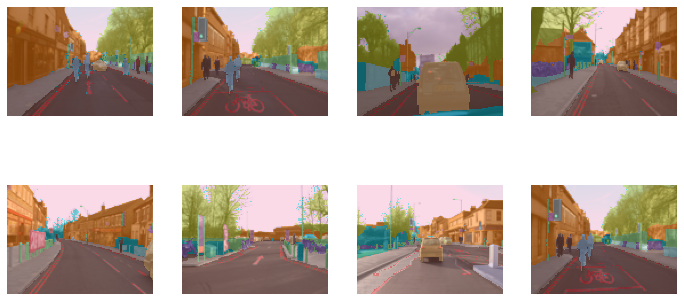

In [ ]:
# show a batch of data, the masks will be overlayed on the images
dls.show_batch()

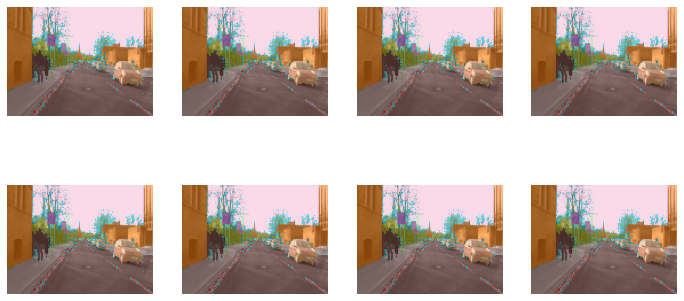

In [ ]:
# check if we are doing data augmentation 
dls.show_batch(unique=True)

In [ ]:
# we get a batch of data as training tensor images and training tensor labels using one_batch()
x, y = dls.one_batch()
# the labels are now images with the same dimensions as the input 
# labels are encoded as integers 
x.shape, y.shape

(torch.Size([8, 3, 96, 128]), torch.Size([8, 96, 128]))

In [ ]:
# we create a unet_learner with a resnet18 backbone

learn = unet_learner(dls, resnet50, pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

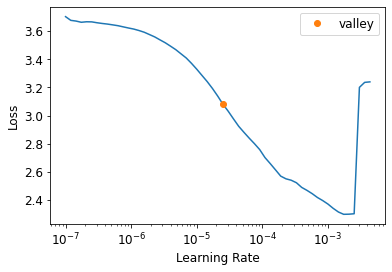

In [ ]:
# find a "good" learning rate
lrs = learn.lr_find()

In [ ]:
?learn.lr_find()

Object `learn.lr_find()` not found.


In [ ]:
lrs

SuggestedLRs(valley=2.511886486900039e-05)

In [ ]:
# fine tune for only two epochs
learn.fine_tune(2, base_lr=lrs.valley)

epoch,train_loss,valid_loss,time
0,3.115223,2.300872,01:05


epoch,train_loss,valid_loss,time
0,1.839214,1.689862,01:05
1,1.620202,1.488381,01:06


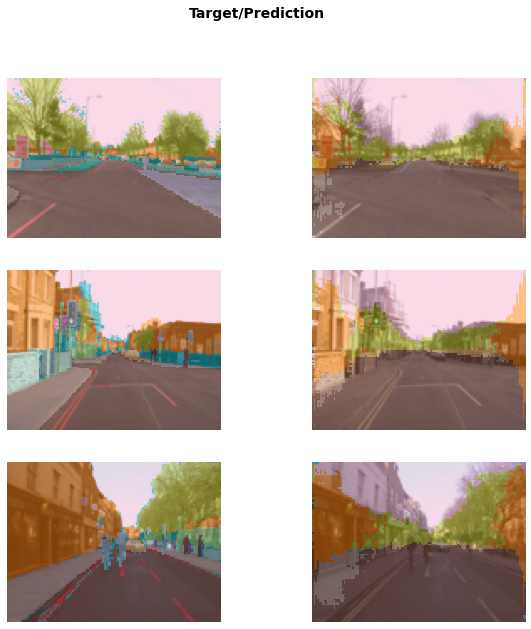

In [ ]:
# see results 
learn.show_results(max_n=3, figsize=(10, 10))

In [ ]:
# train for six more epochs
learn.fine_tune(6, base_lr=lrs.valley)

epoch,train_loss,valid_loss,time
0,1.362832,1.345358,01:05


epoch,train_loss,valid_loss,time
0,1.158180,1.099371,01:07
1,1.101713,1.044010,01:06
2,1.036460,0.914900,01:06
3,0.963769,0.846835,01:06
4,0.906316,0.842191,01:06
5,0.861195,0.830138,01:06


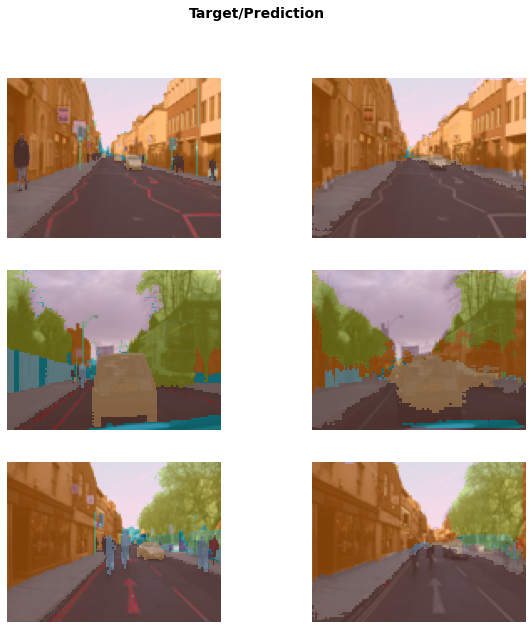

In [ ]:
# see results again
learn.show_results(max_n=3, figsize=(10, 10))

In [ ]:
# train for 10 more epochs, use default learning rate
learn.fine_tune(10)


epoch,train_loss,valid_loss,time
0,6.568980,2.017125,01:04


epoch,train_loss,valid_loss,time
0,1.691557,1.354679,01:06
1,1.496141,1.556312,01:06
2,1.407140,1.099927,01:07
3,1.339418,1.243505,01:06
4,1.276402,1.005624,01:06
5,1.188073,0.880551,01:07
6,1.091545,0.753171,01:06
7,1.004648,0.715590,01:06
8,0.929155,0.704569,01:06
9,0.867522,0.693889,01:06


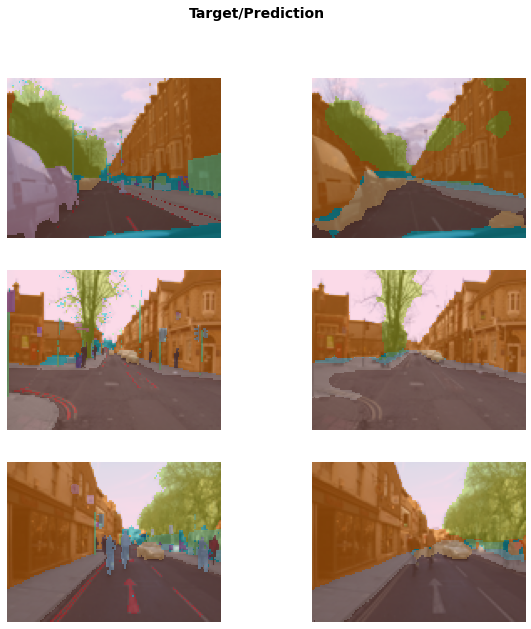

In [ ]:
# results will be ok for many applications (e.g. road or sky segmentation)
# but not particularly impressive for small blobs/objects 
# don't use this to detect cars/pedestrians!  
learn.show_results(max_n=3, figsize=(10, 10))

In [ ]:
learn.export(path / 'trained_unet.pkl')